# Exploring ECHO Data in Your Area
This workbook is a way to quickly view data from EPA's Enforcement and Compliance History Online portal.

Input your zip code into the text box below, then click the "Run" button to see data for your region!

In [1]:
import ipywidgets as widgets
from IPython.display import display
w = widgets.Text("98296")
display(w)

Text(value='98296')

In [21]:
my_zip = w.value
data_location = "data/ECHO_EXPORTER.csv" # Where the ECHO data is saved on your computer in relation to this file

### Below this point, everything is calculated automatically

You don't need to interact with it in order to get it to work, but if you want to dive deeper, you can use it to get started exploring!

In [22]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [23]:
# Get the data
my_cols = ["REGISTRY_ID", "FAC_ZIP", "FAC_QTRS_WITH_NC", "FAC_3YR_COMPLIANCE_HISTORY", "FAC_INSPECTION_COUNT", "FAC_INFORMAL_COUNT", "FAC_FORMAL_ACTION_COUNT", "GHG_CO2_RELEASES"]
echo_data = pd.read_csv(data_location, usecols = my_cols)

# Filter to just your zip code
my_echo = echo_data[echo_data["FAC_ZIP"] == my_zip]

Text(0.5, 1.0, '10 of 27 Total Facilities Noncompliant in 98010')

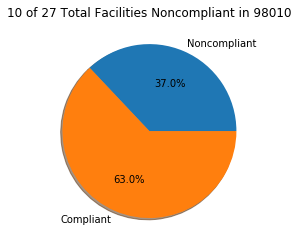

In [24]:
# Get some basic stats on facilities in the zip code
noncompliant = my_echo[my_echo["FAC_QTRS_WITH_NC"] > 0]
plt.pie([noncompliant.shape[0], my_echo.shape[0] - noncompliant.shape[0]], labels=["Noncompliant", "Compliant"], autopct='%1.1f%%', shadow=True)

plt.title("%s of %s Total Facilities Noncompliant in %s" %(noncompliant.shape[0], my_echo.shape[0], my_zip))